## Load reference datasets

In [ ]:
#!pip install xlrd
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris
from scipy import signal


def smooth_line(src: list) -> list:
    return signal.savgol_filter(src, 3, 1)


X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame=True, return_X_y=True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "bc": X_raw_breast_cancer,
    "california": X_raw_california,
    "climate": climate_model_df,
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "slump": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
    ),
    "sonar": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
        header=None,
    ),
    "diabetes": X_raw_diab,
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "yeast": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data",
        sep="\s+",
        header=None,
    ),
    "iris": X_raw_iris,
    "libras": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",
        sep=",",
        header=None,
    ),
    "parkinsons": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",
        sep=",",
    ),
    "yacht": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
        sep="\s+",
        header=None,
    ),
    "ionosphere": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
        sep=",",
        header=None,
    ),
    "letter": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
        header=None,
    ),
    "spam": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    ),
    "credit": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data",
        header=None,
    ),
}

In [ ]:
from pathlib import Path

from hyperimpute.plugins.imputers import Imputers
from hyperimpute.utils.distributions import enable_reproducible_results
import hyperimpute.logger as log

from benchmark_imputation import evaluate_dataset_repeated_internal

enable_reproducible_results()

imputers = Imputers()


def get_imputer():
    return imputers.get(
        "hyperimpute",
        optimizer="simple",
        classifier_seed=["random_forest", "logistic_regression", "xgboost", "catboost"],
        regression_seed=[
            "random_forest_regressor",
            "linear_regression",
            "xgboost_regressor",
            "catboost_regressor",
        ],
    )


def evaluate_dataset_repeated(
    name,
    X_raw,
    y,
    ref_methods=["sklearn_ice", "sklearn_missforest", "sinkhorn", "miwae", "gain"],
    scenarios=["MAR", "MCAR", "MNAR"],
    miss_pct=[0.3],
    n_iter=3,
    debug=False,
):
    return evaluate_dataset_repeated_internal(
        name=name,
        evaluated_model=get_imputer(),
        X_raw=X_raw,
        y=y,
        ref_methods=ref_methods,
        scenarios=scenarios,
        miss_pct=miss_pct,
        n_iter=n_iter,
        debug=debug,
    )

## By dataset size

In [3]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
    header=None,
)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col])

last_col = df.columns[-1]
y = df[last_col]
X_raw = df.drop(columns=[last_col])

X_raw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,19,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0
1,8,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4
2,3,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3
3,13,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2
4,6,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3
19996,2,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3
19997,19,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2
19998,18,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5


In [ ]:
import json

results_by_df_size = {}
for subsample in [1000, 4000, 7000, 10000, 13000, 17000, 20000]:
    try:
        with open("general_results/error_by_df_size.json") as f:
            results_by_df_size = json.load(f)
    except BaseException:
        pass

    if str(subsample) in results_by_df_size:
        print("subsample already cached", subsample)
        continue

    print("subsample eval", subsample)
    X_local = X_raw.sample(subsample)
    y_local = y[X_local.index]

    results_by_df_size[subsample] = evaluate_dataset_repeated(
        f"subsample_{subsample}", X_local, y_local
    )

    with open("general_results/error_by_df_size.json", "w") as f:
        json.dump(results_by_df_size, f)

## By feature count

In [ ]:
import json

results_by_feat_count = {}

for feat_count in [2, 4, 6, 8, 10, 12, 14]:
    try:
        with open("general_results/error_by_df_feat_count.json") as f:
            results_by_feat_count = json.load(f)
    except BaseException:
        pass

    if str(feat_count) in results_by_feat_count:
        print("feat count cached", feat_count)
        continue

    print("eval feat count", feat_count)

    X_local = X_raw.sample(2000)
    y_local = y[X_local.index]
    X_local = X_local.iloc[:, :feat_count]

    results_by_feat_count[feat_count] = evaluate_dataset_repeated(
        f"feature_subsample_{feat_count}", X_local, y_local
    )

    with open("general_results/error_by_df_feat_count.json", "w") as f:
        json.dump(results_by_feat_count, f)

# Plots

## Plot error by df size

scenario MAR


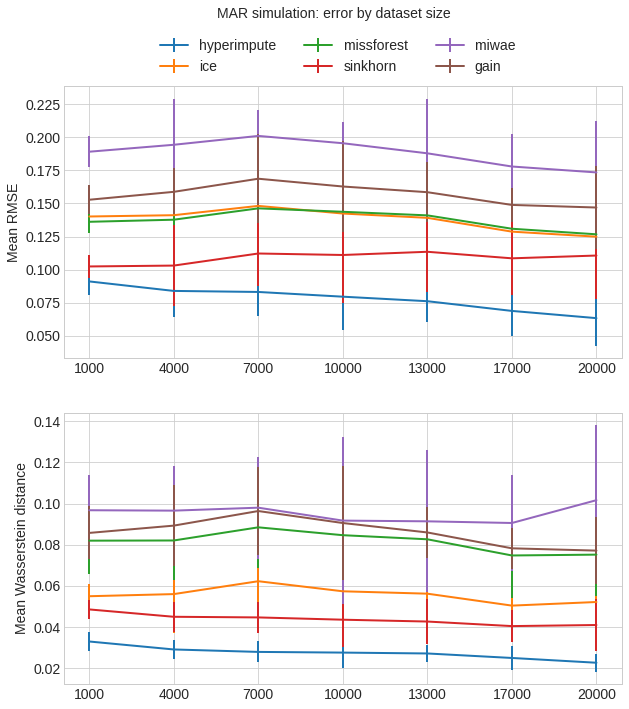

scenario MCAR


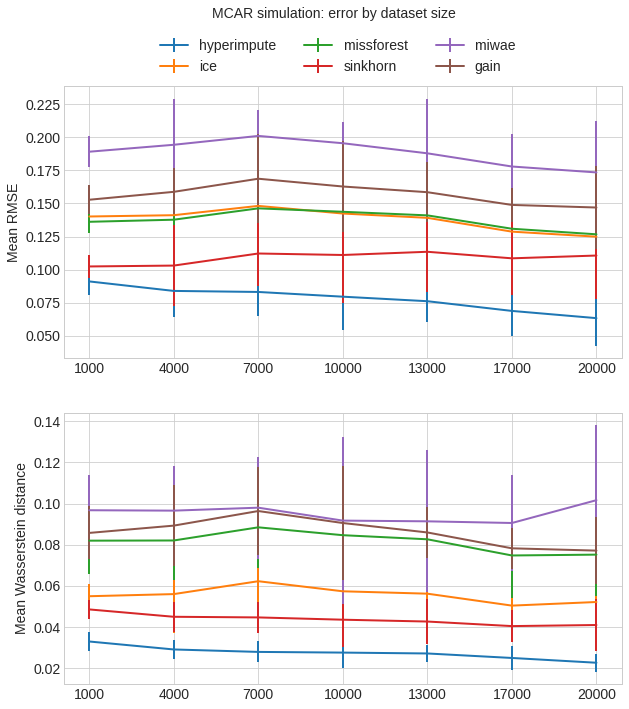

scenario MNAR


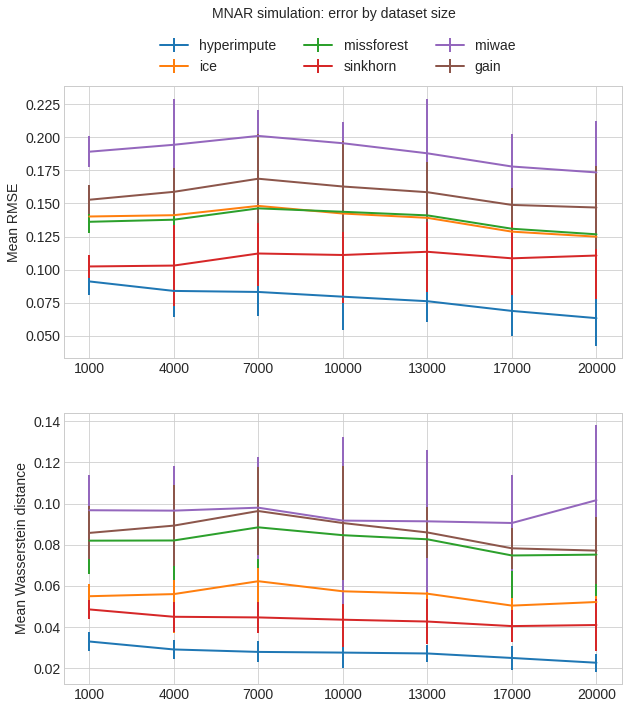

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = list(results_by_df_size.keys())
x_axis = np.asarray(x_axis)

fontsize = 14

output_dir = Path("diagrams")
output_dir.mkdir(parents=True, exist_ok=True)


map_keys = {"rmse": "Mean RMSE", "wasserstein": "Mean Wasserstein distance"}


def generate_plot_for_ax(ax, error_by_df_size_plots, metric):
    for model in error_by_df_size_plots[metric]:
        datapoints = error_by_df_size_plots[metric][model]["mean"]
        datapoints_std = error_by_df_size_plots[metric][model]["std"]

        ax.errorbar(
            np.asarray(x_axis),
            smooth_line(np.asarray(datapoints)),
            yerr=np.asarray(datapoints_std),
            label=str(model),
            linewidth=2,
        )

    ax.set_xticks(x_axis, fontsize=fontsize)
    ax.set_ylabel(map_keys[metric], fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(error_by_df_size_plots, scenario):
    plt.style.use("seaborn-whitegrid")

    metrics = list(["rmse", "wasserstein"])
    fig, axs = plt.subplots(len(metrics), figsize=(10, 11))

    for idx, metric in enumerate(error_by_df_size_plots.keys()):
        generate_plot_for_ax(axs[idx], error_by_df_size_plots, metric)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.15, 1.22),
        ncol=int(len(error_by_df_size_plots["rmse"]) / 2),
        prop={"size": fontsize},
    )
    fig.suptitle(f"{scenario} simulation: error by dataset size", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_df_size_{scenario}.png")

    plt.show()


error_by_df_size_plots = {"rmse": {}, "wasserstein": {}}


for size in results_by_df_size:
    headers = results_by_df_size[size]["headers"][2:]
    headers[0] = "hyperimpute"
    headers[1] = "ice"
    headers[2] = "missforest"

    rmse = results_by_df_size[size]["rmse"][0][2:]
    wasserstein = results_by_df_size[size]["wasserstein"][0][2:]

    for idx, header in enumerate(headers):
        if header not in error_by_df_size_plots["rmse"]:
            error_by_df_size_plots["rmse"][header] = {"mean": [], "std": []}
            error_by_df_size_plots["wasserstein"][header] = {"mean": [], "std": []}

        error_by_df_size_plots["rmse"][header]["mean"].append(rmse[idx][0])
        error_by_df_size_plots["rmse"][header]["std"].append(rmse[idx][1])
        error_by_df_size_plots["wasserstein"][header]["mean"].append(
            wasserstein[idx][0]
        )
        error_by_df_size_plots["wasserstein"][header]["std"].append(wasserstein[idx][1])

for scenario in ["MAR", "MCAR", "MNAR"]:
    print("scenario", scenario)
    generate_plot(error_by_df_size_plots, scenario=scenario)

# By feature size



scenario  MAR


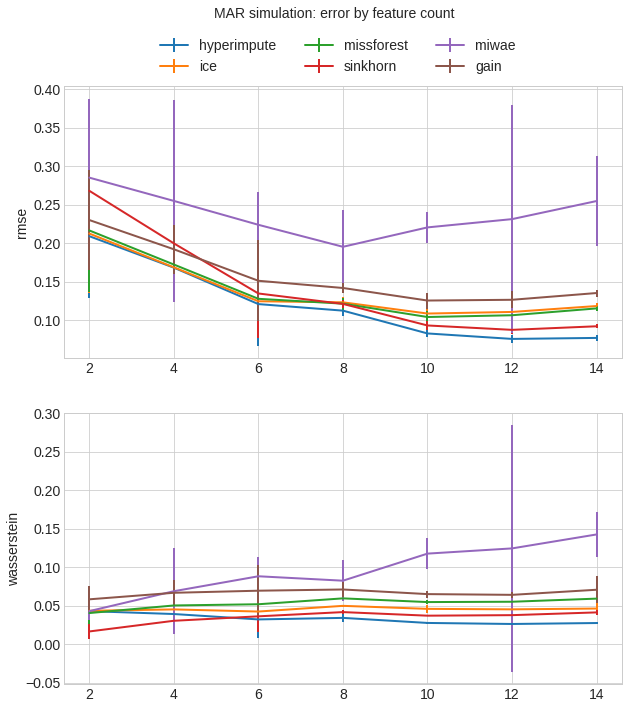

scenario  MCAR


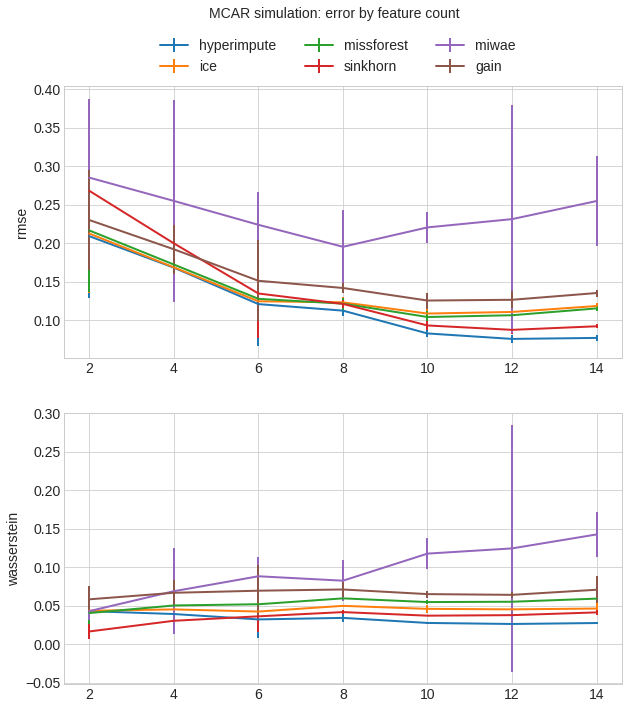

scenario  MNAR


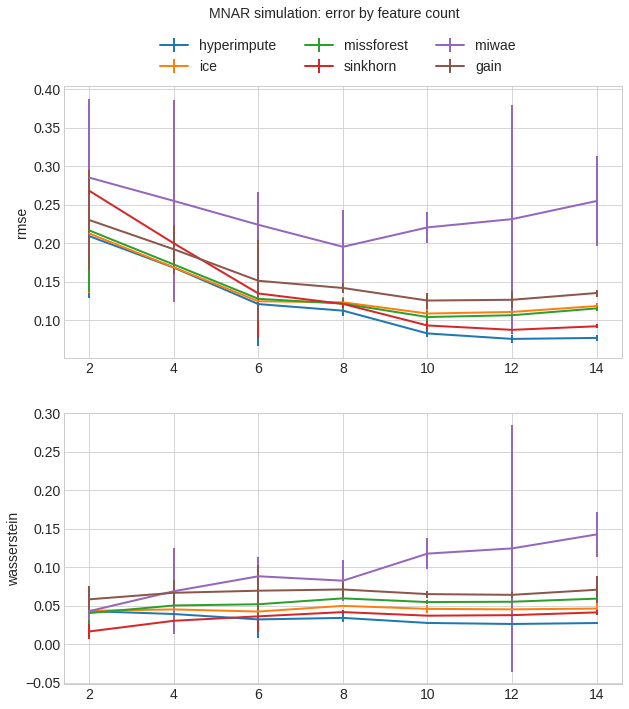

In [7]:
import numpy as np

x_axis = list(results_by_feat_count.keys())
x_axis = np.asarray(x_axis)

fontsize = 14


def generate_plot_for_ax(ax, error_by_feat_count_plots, metric):
    ## We selected the same dataset from every model, and average across missingness pct
    for model in error_by_feat_count_plots[metric]:
        datapoints = error_by_feat_count_plots[metric][model]["mean"]
        datapoints_std = error_by_feat_count_plots[metric][model]["std"]

        ax.errorbar(
            np.asarray(x_axis),
            smooth_line(np.asarray(datapoints)),
            yerr=np.asarray(datapoints_std),
            label=str(model),
            linewidth=2,
        )

    ax.set_xticks(x_axis, fontsize=fontsize)
    ax.set_ylabel(map_keys[metric], fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot(error_by_feat_count_plots, scenario):
    plt.style.use("seaborn-whitegrid")

    metrics = ["rmse", "wasserstein"]
    fig, axs = plt.subplots(len(metrics), figsize=(10, 11))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax(axs[idx], error_by_feat_count_plots, metric)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.15, 1.22),
        ncol=int(len(error_by_feat_count_plots["rmse"]) / 2),
        prop={"size": fontsize},
    )
    fig.suptitle(f"{scenario} simulation: error by feature count", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_feature_cnt_{scenario}.png")

    plt.show()


error_by_feat_count_plots = {"rmse": {}, "wasserstein": {}}


for feat_count in results_by_feat_count:
    headers = results_by_feat_count[feat_count]["headers"][2:]
    headers[0] = "hyperimpute"
    headers[1] = "ice"
    headers[2] = "missforest"

    rmse = results_by_feat_count[feat_count]["rmse"][0][2:]
    wasserstein = results_by_feat_count[feat_count]["wasserstein"][0][2:]

    for idx, header in enumerate(headers):
        if header not in error_by_feat_count_plots["rmse"]:
            error_by_feat_count_plots["rmse"][header] = {"mean": [], "std": []}
            error_by_feat_count_plots["wasserstein"][header] = {"mean": [], "std": []}

        error_by_feat_count_plots["rmse"][header]["mean"].append(rmse[idx][0])
        error_by_feat_count_plots["rmse"][header]["std"].append(rmse[idx][1])
        error_by_feat_count_plots["wasserstein"][header]["mean"].append(
            wasserstein[idx][0]
        )
        error_by_feat_count_plots["wasserstein"][header]["std"].append(
            wasserstein[idx][1]
        )

for scenario in ["MAR", "MCAR", "MNAR"]:
    print("scenario ", scenario)
    generate_plot(error_by_feat_count_plots, scenario)